In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [75]:
import json
import re
import matplotlib

# 한글 품사 태깅을 위한 모듈
from konlpy.tag import Okt
from collections import Counter
from matplotlib import font_manager, rc
from wordcloud import WordCloud

plt.rcParams['font.family'] = 'NanumGothic'

In [76]:
file2 = '../변수정리/csv파일/final_data_set_v3.csv'

In [77]:
# final_data_set_v2.csv 열기 --> 정답 데이터를 일단 분석해보기
# 왜냐면 나눈 것이 잘 나눠졌나 확인하려고
raw1 = pd.read_csv(file2, index_col=0)
df1 = raw1.copy()
df1.head(1)

,Attraction,Category,type,Category_Map,Category_Map_v2,Good_Point,Selected_People,Selected_People_Ratio,Participants,Address,Tag,Longitude,Latitude,Image Link
0,104고지전적비,관광,history,매력도,분위기,사진이 잘 나와요,91.0,0.250689,203,서울특별시 서대문구 연희동 산100-1,#관광지#기념탑#역사#역사공부#역사관광지#역사를품은곳#역사문화재#역사속#역사속으로#...,126.926214,37.567794,https://dbscthumb-phinf.pstatic.net/2765_000_1...


In [78]:
# 아직 분류 전 DF : 사용할 Tag만 사용
df_tag = df1[['Attraction', 'Category', 'Tag']].drop_duplicates().reset_index(drop=True)
print(df_tag.shape)
df_tag.head(2)

(785, 3)


,Attraction,Category,Tag
0,104고지전적비,관광,#관광지#기념탑#역사#역사공부#역사관광지#역사를품은곳#역사문화재#역사속#역사속으로#...
1,10꼬르소꼬모 청담점,관광,#10꼬르소꼬모#10꼬르소꼬모청담점#강남브런치카페#쇼핑#음식#청담동카페#청담동편집숍...


In [79]:
df_tag['Category'].value_counts()

Category
음식    449
관광    336
Name: count, dtype: int64

In [80]:
df_tag['Category'] == '관광'

0       True
1       True
2       True
3       True
4       True
       ...  
780    False
781    False
782    False
783    False
784    False
Name: Category, Length: 785, dtype: bool

In [81]:
df_tag_tour = df_tag[df_tag['Category'] == '관광']
df_tag_food = df_tag[df_tag['Category'] == '음식']

In [82]:
df_tag_tour.info()

<class 'pandas.core.frame.DataFrame'>
Index: 336 entries, 0 to 335
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Attraction  336 non-null    object
 1   Category    336 non-null    object
 2   Tag         336 non-null    object
dtypes: object(3)
memory usage: 10.5+ KB


In [83]:
df_tag_food.info()

<class 'pandas.core.frame.DataFrame'>
Index: 449 entries, 336 to 784
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Attraction  449 non-null    object
 1   Category    449 non-null    object
 2   Tag         449 non-null    object
dtypes: object(3)
memory usage: 14.0+ KB


In [84]:
df_tag_food = df_tag_food[['Attraction', 'Category', 'Tag']].drop_duplicates().reset_index(drop=True)
print(df_tag_food.shape)

(449, 3)


In [85]:
df_tag_food

,Attraction,Category,Tag
0,채그로,음식,#독서#마포구가볼만한곳#복합문화시설#북카페#서울#쇼핑#채그로#책#힐링공간
1,소소한 풍경,음식,#맛집#부암동맛집#부암동소소한풍경#부암동전망좋은식당#부암동한정식#소소한풍경#음식#전...
2,마복림할머니집,음식,#떡볶이#마복림#마복림떡볶이#맛집#서울맛집추천#신당동떡볶이#신당동맛집#음식#즉석떡볶이
3,뮤직컴플렉스 서울,음식,#LP카페#가볼래터#뮤직카페#뮤직컴플렉스서울#여행구독#음식#음악카페#이색체험#이색카...
4,또순이네집,음식,#또순이네#또순이네된장찌개#양평동또순이네#영등포또순이네#음식#주물럭맛집
...,...,...,...
444,해담채 삼성점,음식,#강남맛집#음식#코스요리#해담채
445,까사빠보 신세계백화점본점,음식,#민물장어덮밥#서울중구맛집#식품의약품안전처_음식점위생등급_매우우수(2017년)#음식...
446,포포인츠 바이 쉐라톤 조선 서울역 더 이터리,음식,#담백한_맛뷔페#뷔페#식품의약품안전처_음식점위생등급_매우우수(2017년)#용산맛집#...
447,오양회참치 광화문본점,음식,#맛집#분위기_좋은#생복탕#음식#전복죽#참다랑어회#초밥#회정식


### 태그 전처리

In [86]:
# 함수 만들기
def make_newTagCols(df, nlp):
    # tag 분리한거 담는 컬럼 만들기
    df[['newTag', 'newTag_list', 'tag_word_N']] = None
    # 모든 태그 모음집
    total = ''
    # 모든 태그의 명사 추출 모음집
    N_list = []

    # '#' 분리해서 컬럼에 담기
    for i, tag in enumerate(df.Tag):
        tag = tag.split('#')[1:]
        df['newTag_list'][i] = tag
    
        words = ''
        for t in tag:
            words = words + t + ' '
    
        total = total + words + ' '
        df['newTag'][i] = words

        # 명사 추출해서 또 새로운 컬럼에 담기
        newTag_N = list(set(nlp.nouns(words)))
        N_list.append(newTag_N)
        df['tag_word_N'][i] = newTag_N
        
    # '#'제거 해시태그 한 리스트에 모은 것 : total
    # total에서 명사 추출한 결과
    total_nouns = nlp.nouns(total)

    return df, total, N_list, total_nouns

관광부터 추출 & 시각화

In [87]:
# 한글 단어 구분
nlp = Okt()

df_tag_food, total_word, newTag_N_list, total_nouns = make_newTagCols(df_tag_food, nlp)

In [88]:
len(df_tag_food)

449

단어 정제
- 빈출 단어 제거

In [89]:
count = Counter(total_nouns)

In [90]:
word_count = dict()

# 빈출 단어 50위까지 word_count에 넣어주는 코드
for tag, counts in count.most_common(50):
    if (len(str(tag))>1):
        word_count[tag] = counts
        print(f'{tag} : {counts}')

맛집 : 722
음식 : 468
서울 : 154
카페 : 91
갈비 : 67
요리 : 63
한식 : 60
한우 : 60
추천 : 49
음식점 : 44
정식 : 43
코스 : 42
한정식 : 40
여행 : 36
분위기 : 36
냉면 : 33
구이 : 32
수도권 : 32
칼국수 : 32
식당 : 31
위생 : 30
등급 : 30
등심 : 28
남녀 : 27
노소 : 27
강남 : 27
중구 : 26
서울시 : 25
가족 : 25
종로구 : 24
스테이크 : 24
불고기 : 22
식사 : 22
종로 : 20
휴식 : 20
양념 : 20
레스토랑 : 20
연인 : 19
만두 : 19
디저트 : 18
족발 : 18
중식 : 17
감성 : 16
이색 : 15
낙지 : 15


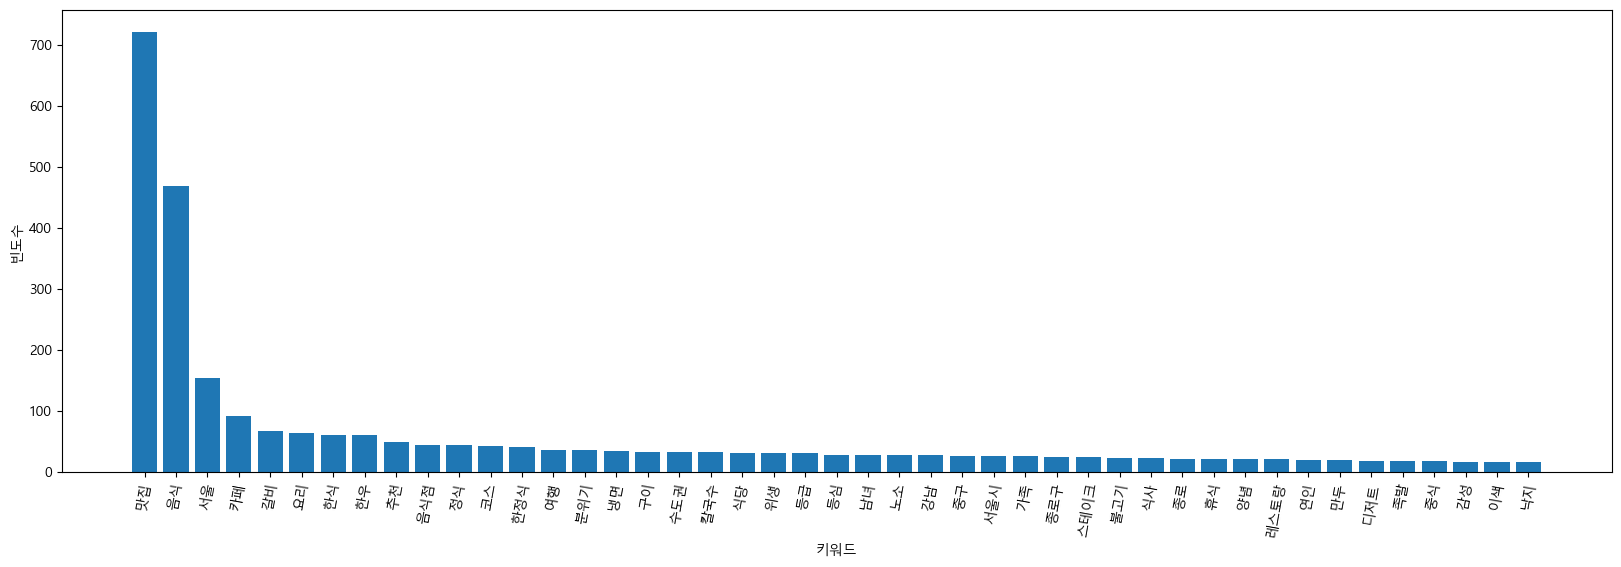

In [91]:
font_path = "c:/Windows/fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname = font_path).get_name()
matplotlib.rc('font', family = font_name)

plt.figure(figsize = (20, 6))
plt.xlabel('키워드')
plt.ylabel('빈도수')
# plt.grid(True)

sorted_Keys = sorted(word_count, key = word_count.get, reverse = True)
sorted_Values = sorted(word_count.values(), reverse = True)

plt.bar(range(len(word_count)), sorted_Values, align = 'center')

plt.xticks(range(len(word_count)), list(sorted_Keys), rotation = 80)
plt.show()

In [93]:
df_tag_food['tag_word_N']

0      [그로, 복합, 책, 북카페, 공간, 문화, 시설, 힐링, 곳, 마포구, 독서, 쇼...
1                     [한정식, 식당, 풍경, 맛집, 전망, 퓨전, 부암동, 음식]
2                      [마, 추천, 맛집, 음식, 신당동, 복림, 떡볶이, 서울]
3      [터, 이색, 인사동, 구독, 컴플렉스, 여행, 카페, 음식, 곳, 음악, 뮤직, ...
4                   [된장찌개, 럭, 맛집, 주물, 영등포, 또순이, 양평동, 음식]
                             ...                        
444                          [담채, 맛집, 해, 요리, 코스, 음식, 강남]
445    [함박스테이크, 음식점, 민물장어, 중구, 위생, 우수, 맛집, 밥, 등급, 음식,...
446    [맛, 음식점, 위생, 우수, 맛집, 등급, 용산, 음식, 매우, 뷔페, 식품의약품...
447             [회정, 초밥, 맛집, 전복죽, 생복탕, 회, 참다랑어, 분위기, 음식]
448    [레스토랑, 위생, 우수, 여행, 맛집, 스테이크, 연인, 등급, 음식, 양식, 매...
Name: tag_word_N, Length: 449, dtype: object

In [94]:
df_tag_food

,Attraction,Category,Tag,newTag,newTag_list,tag_word_N
0,채그로,음식,#독서#마포구가볼만한곳#복합문화시설#북카페#서울#쇼핑#채그로#책#힐링공간,독서 마포구가볼만한곳 복합문화시설 북카페 서울 쇼핑 채그로 책 힐링공간,"[독서, 마포구가볼만한곳, 복합문화시설, 북카페, 서울, 쇼핑, 채그로, 책, 힐링공간]","[그로, 복합, 책, 북카페, 공간, 문화, 시설, 힐링, 곳, 마포구, 독서, 쇼..."
1,소소한 풍경,음식,#맛집#부암동맛집#부암동소소한풍경#부암동전망좋은식당#부암동한정식#소소한풍경#음식#전...,맛집 부암동맛집 부암동소소한풍경 부암동전망좋은식당 부암동한정식 소소한풍경 음식 전망...,"[맛집, 부암동맛집, 부암동소소한풍경, 부암동전망좋은식당, 부암동한정식, 소소한풍경...","[한정식, 식당, 풍경, 맛집, 전망, 퓨전, 부암동, 음식]"
2,마복림할머니집,음식,#떡볶이#마복림#마복림떡볶이#맛집#서울맛집추천#신당동떡볶이#신당동맛집#음식#즉석떡볶이,떡볶이 마복림 마복림떡볶이 맛집 서울맛집추천 신당동떡볶이 신당동맛집 음식 즉석떡볶이,"[떡볶이, 마복림, 마복림떡볶이, 맛집, 서울맛집추천, 신당동떡볶이, 신당동맛집, ...","[마, 추천, 맛집, 음식, 신당동, 복림, 떡볶이, 서울]"
3,뮤직컴플렉스 서울,음식,#LP카페#가볼래터#뮤직카페#뮤직컴플렉스서울#여행구독#음식#음악카페#이색체험#이색카...,LP카페 가볼래터 뮤직카페 뮤직컴플렉스서울 여행구독 음식 음악카페 이색체험 이색카페...,"[LP카페, 가볼래터, 뮤직카페, 뮤직컴플렉스서울, 여행구독, 음식, 음악카페, 이...","[터, 이색, 인사동, 구독, 컴플렉스, 여행, 카페, 음식, 곳, 음악, 뮤직, ..."
4,또순이네집,음식,#또순이네#또순이네된장찌개#양평동또순이네#영등포또순이네#음식#주물럭맛집,또순이네 또순이네된장찌개 양평동또순이네 영등포또순이네 음식 주물럭맛집,"[또순이네, 또순이네된장찌개, 양평동또순이네, 영등포또순이네, 음식, 주물럭맛집]","[된장찌개, 럭, 맛집, 주물, 영등포, 또순이, 양평동, 음식]"
...,...,...,...,...,...,...
444,해담채 삼성점,음식,#강남맛집#음식#코스요리#해담채,강남맛집 음식 코스요리 해담채,"[강남맛집, 음식, 코스요리, 해담채]","[담채, 맛집, 해, 요리, 코스, 음식, 강남]"
445,까사빠보 신세계백화점본점,음식,#민물장어덮밥#서울중구맛집#식품의약품안전처_음식점위생등급_매우우수(2017년)#음식...,민물장어덮밥 서울중구맛집 식품의약품안전처_음식점위생등급_매우우수(2017년) 음식 ...,"[민물장어덮밥, 서울중구맛집, 식품의약품안전처_음식점위생등급_매우우수(2017년),...","[함박스테이크, 음식점, 민물장어, 중구, 위생, 우수, 맛집, 밥, 등급, 음식,..."
446,포포인츠 바이 쉐라톤 조선 서울역 더 이터리,음식,#담백한_맛뷔페#뷔페#식품의약품안전처_음식점위생등급_매우우수(2017년)#용산맛집#...,담백한_맛뷔페 뷔페 식품의약품안전처_음식점위생등급_매우우수(2017년) 용산맛집 음...,"[담백한_맛뷔페, 뷔페, 식품의약품안전처_음식점위생등급_매우우수(2017년), 용산...","[맛, 음식점, 위생, 우수, 맛집, 등급, 용산, 음식, 매우, 뷔페, 식품의약품..."
447,오양회참치 광화문본점,음식,#맛집#분위기_좋은#생복탕#음식#전복죽#참다랑어회#초밥#회정식,맛집 분위기_좋은 생복탕 음식 전복죽 참다랑어회 초밥 회정식,"[맛집, 분위기_좋은, 생복탕, 음식, 전복죽, 참다랑어회, 초밥, 회정식]","[회정, 초밥, 맛집, 전복죽, 생복탕, 회, 참다랑어, 분위기, 음식]"


In [51]:
# temp_list = []

# for i in range(len(df_tag_tour)):
#     for j in range(len(df_tag_tour['tag_word_N'][i])):
#         if df_tag_tour['tag_word_N'][i][j] not in word_50:
#             temp_list = temp_list.append(df_tag_tour['tag_word_N'][i][j])
#             df_tag_tour['tag_word_N'][i] = temp_list
#         else:
#             continue

In [95]:
df_tag_food

,Attraction,Category,Tag,newTag,newTag_list,tag_word_N
0,채그로,음식,#독서#마포구가볼만한곳#복합문화시설#북카페#서울#쇼핑#채그로#책#힐링공간,독서 마포구가볼만한곳 복합문화시설 북카페 서울 쇼핑 채그로 책 힐링공간,"[독서, 마포구가볼만한곳, 복합문화시설, 북카페, 서울, 쇼핑, 채그로, 책, 힐링공간]","[그로, 복합, 책, 북카페, 공간, 문화, 시설, 힐링, 곳, 마포구, 독서, 쇼..."
1,소소한 풍경,음식,#맛집#부암동맛집#부암동소소한풍경#부암동전망좋은식당#부암동한정식#소소한풍경#음식#전...,맛집 부암동맛집 부암동소소한풍경 부암동전망좋은식당 부암동한정식 소소한풍경 음식 전망...,"[맛집, 부암동맛집, 부암동소소한풍경, 부암동전망좋은식당, 부암동한정식, 소소한풍경...","[한정식, 식당, 풍경, 맛집, 전망, 퓨전, 부암동, 음식]"
2,마복림할머니집,음식,#떡볶이#마복림#마복림떡볶이#맛집#서울맛집추천#신당동떡볶이#신당동맛집#음식#즉석떡볶이,떡볶이 마복림 마복림떡볶이 맛집 서울맛집추천 신당동떡볶이 신당동맛집 음식 즉석떡볶이,"[떡볶이, 마복림, 마복림떡볶이, 맛집, 서울맛집추천, 신당동떡볶이, 신당동맛집, ...","[마, 추천, 맛집, 음식, 신당동, 복림, 떡볶이, 서울]"
3,뮤직컴플렉스 서울,음식,#LP카페#가볼래터#뮤직카페#뮤직컴플렉스서울#여행구독#음식#음악카페#이색체험#이색카...,LP카페 가볼래터 뮤직카페 뮤직컴플렉스서울 여행구독 음식 음악카페 이색체험 이색카페...,"[LP카페, 가볼래터, 뮤직카페, 뮤직컴플렉스서울, 여행구독, 음식, 음악카페, 이...","[터, 이색, 인사동, 구독, 컴플렉스, 여행, 카페, 음식, 곳, 음악, 뮤직, ..."
4,또순이네집,음식,#또순이네#또순이네된장찌개#양평동또순이네#영등포또순이네#음식#주물럭맛집,또순이네 또순이네된장찌개 양평동또순이네 영등포또순이네 음식 주물럭맛집,"[또순이네, 또순이네된장찌개, 양평동또순이네, 영등포또순이네, 음식, 주물럭맛집]","[된장찌개, 럭, 맛집, 주물, 영등포, 또순이, 양평동, 음식]"
...,...,...,...,...,...,...
444,해담채 삼성점,음식,#강남맛집#음식#코스요리#해담채,강남맛집 음식 코스요리 해담채,"[강남맛집, 음식, 코스요리, 해담채]","[담채, 맛집, 해, 요리, 코스, 음식, 강남]"
445,까사빠보 신세계백화점본점,음식,#민물장어덮밥#서울중구맛집#식품의약품안전처_음식점위생등급_매우우수(2017년)#음식...,민물장어덮밥 서울중구맛집 식품의약품안전처_음식점위생등급_매우우수(2017년) 음식 ...,"[민물장어덮밥, 서울중구맛집, 식품의약품안전처_음식점위생등급_매우우수(2017년),...","[함박스테이크, 음식점, 민물장어, 중구, 위생, 우수, 맛집, 밥, 등급, 음식,..."
446,포포인츠 바이 쉐라톤 조선 서울역 더 이터리,음식,#담백한_맛뷔페#뷔페#식품의약품안전처_음식점위생등급_매우우수(2017년)#용산맛집#...,담백한_맛뷔페 뷔페 식품의약품안전처_음식점위생등급_매우우수(2017년) 용산맛집 음...,"[담백한_맛뷔페, 뷔페, 식품의약품안전처_음식점위생등급_매우우수(2017년), 용산...","[맛, 음식점, 위생, 우수, 맛집, 등급, 용산, 음식, 매우, 뷔페, 식품의약품..."
447,오양회참치 광화문본점,음식,#맛집#분위기_좋은#생복탕#음식#전복죽#참다랑어회#초밥#회정식,맛집 분위기_좋은 생복탕 음식 전복죽 참다랑어회 초밥 회정식,"[맛집, 분위기_좋은, 생복탕, 음식, 전복죽, 참다랑어회, 초밥, 회정식]","[회정, 초밥, 맛집, 전복죽, 생복탕, 회, 참다랑어, 분위기, 음식]"


In [96]:
news_texts = df_tag_food['tag_word_N']

In [97]:
news_texts.shape

(449,)

In [98]:
# gensim 모듈에서 제공하는 corpora : 문서 - 단어 행렬을 생성하고 관리함
from gensim import corpora

# corpora의 Dictionary 함수를 사용하여 news_texts 리스트에서 단어 사전을 생성
# 토큰화되어있는 news_texts에서 각 단어들에 고유한 ID를 할당하고 해당 ID의 매핑을 관리
# 즉, dictionary는 각 단어와 해당 단어의 고유 ID를 포함하는 사전
dictionary = corpora.Dictionary(news_texts)

# 리스트 컴프리헨션 해석
# news_texts에서 text를 하나씩 뽑아와서 Bag-of-Words 형식으로 변환
# BoW 형식 : (단어ID, 해당 단어의 빈도 수) 튜플 형식의 리스트
# 예시 - ['word1', 'word2', 'word1']라는 문서는 [(0, 2), (1, 1)]으로 변환 / 여기서 0과 1은 word1과 word2의 ID이며, 2와 1은 각 단어의 빈도이다
corpus = [dictionary.doc2bow(text) for text in news_texts]

print(corpus[1])

[(14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1)]


In [99]:
# gensim에서 제공하는 Lda 모델
from gensim.models import LdaModel

# corpus : BoW 형식으로 변환된 문서-단어 행렬
# num_topics : 추출할 주제의 수
# id2word : 단어 ID와 단어의 매핑을 제공하는 사전
lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, random_state=42)
topics = lda_model.print_topics()
topics

[(0,
  '0.045*"음식" + 0.024*"맛집" + 0.021*"서울" + 0.012*"카페" + 0.011*"탕" + 0.008*"여행" + 0.007*"구독" + 0.007*"이색" + 0.007*"터" + 0.007*"밥"'),
 (1,
  '0.082*"음식" + 0.081*"맛집" + 0.027*"서울" + 0.016*"추천" + 0.008*"칼국수" + 0.007*"요리" + 0.007*"종로구" + 0.006*"만두" + 0.006*"중구" + 0.006*"코스"'),
 (2,
  '0.084*"음식" + 0.075*"맛집" + 0.022*"서울" + 0.012*"요리" + 0.012*"노소" + 0.012*"남녀" + 0.011*"수도권" + 0.010*"정식" + 0.009*"한식" + 0.009*"여행"'),
 (3,
  '0.075*"음식" + 0.065*"맛집" + 0.026*"서울" + 0.009*"카페" + 0.008*"식당" + 0.008*"추천" + 0.007*"한식" + 0.007*"분위기" + 0.006*"연인" + 0.006*"종로"'),
 (4,
  '0.078*"음식" + 0.073*"맛집" + 0.017*"요리" + 0.013*"코스" + 0.012*"갈비" + 0.012*"서울" + 0.010*"등심" + 0.010*"음식점" + 0.010*"분위기" + 0.009*"추천"')]

In [122]:
# CoherenceModel : 주제의 일관성을 평가하는 지표 높을수록 주제의 일관성이 높다
from gensim.models.coherencemodel import CoherenceModel

# 주제의 개수 최소 최대값 지정
min_topics, max_topics = 3, 10
# 최소~최대 범위내의 coherence score 담을 리스트
coherence_score = []

# 최소~최대 범위에서 각 주제 개수에 해당하는 coherence score 구하는 반복문
for num_topics in range(min_topics, max_topics):
    model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, random_state=42)
    coherence = CoherenceModel(model=model,
                               texts=news_texts,
                               dictionary=dictionary)
    coherence_score.append(coherence.get_coherence())
    
print(coherence_score)

[0.2943809571176467, 0.27222349747577185, 0.30271252555979417, 0.34830904308983923, 0.3252705890123026, 0.3136218703046638, 0.353742871459254]


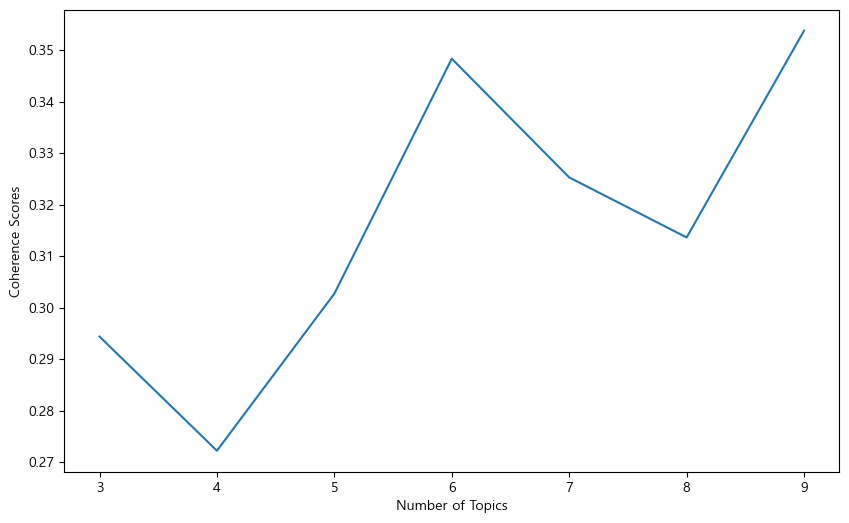

In [123]:
# coherence score 결과 시각화
import matplotlib.pyplot as plt

x = [i for i in range(min_topics, max_topics)]

plt.figure(figsize=(10,6))
plt.plot(x, coherence_score)
# x축 값 : 최소~최대 범위의 수
# y축 값 : 반복문으로 추출한 coherence_score
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Scores')
plt.show()

# 토픽의 수가 21일때 가장 높은 점수를 보인다.

In [140]:
# 점수가 가장 높은 토픽수를 반영하여 다시 추출

lda_model = LdaModel(corpus, num_topics=3, id2word=dictionary, random_state=42)
topics = lda_model.print_topics(num_topics=3)
topics

[(0,
  '0.058*"음식" + 0.048*"맛집" + 0.025*"서울" + 0.010*"수도권" + 0.008*"노소" + 0.008*"한우" + 0.008*"남녀" + 0.007*"구이" + 0.007*"갈비" + 0.007*"카페"'),
 (1,
  '0.092*"음식" + 0.085*"맛집" + 0.013*"서울" + 0.012*"요리" + 0.009*"코스" + 0.008*"분위기" + 0.008*"탕" + 0.007*"음식점" + 0.007*"갈비" + 0.007*"추천"'),
 (2,
  '0.070*"음식" + 0.063*"맛집" + 0.027*"서울" + 0.015*"한식" + 0.014*"추천" + 0.011*"요리" + 0.010*"정식" + 0.007*"수도권" + 0.007*"식당" + 0.006*"카페"')]

In [141]:
# perplexity: 모델의 성능을 평가하는 지표로, 낮을수록 좋음

perplexity = lda_model.log_perplexity(corpus)
print(f"Perplexity: {perplexity}")

Perplexity: -6.447751093464964


토픽 모델링 시각화

In [142]:
# pyLDAvis : LDA 분석 결과를 시각화해주는 모듈
import pyLDAvis.gensim

# pyLDAvis의 노트북 모드를 활성화 >> Jupyter Notebook에서 시각화 결과를 바로 직접 볼 수 있도록 하기 위함
pyLDAvis.enable_notebook()

# pyLDAvis.gensim.prepare() : LDA 모델의 시각화 준비하는 코드
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)

# 준비된 시각화를 노트북에서 표시
pyLDAvis.display(vis)

In [ ]:
# pyLDAvis.save_html(vis, './관광_vis.html')

각 관광지가 어디 주제에 속하는 지 라벨링하는 코드

In [66]:
doc_topic_dist = lda_model[corpus]
doc_topic_dist

In [67]:
import pandas as pd

# 각 문서의 주제 분포를 수집할 리스트
doc_topic_list = []

for i, doc in enumerate(doc_topic_dist):
    # 각 문서의 주제 분포를 딕셔너리로 변환
    topic_probs = {f"Topic {topic_id}": prob for topic_id, prob in doc}
    # 문서 ID를 딕셔너리에 추가
    topic_probs["Document"] = i
    doc_topic_list.append(topic_probs)

# 리스트를 DataFrame으로 변환
doc_topic_df = pd.DataFrame(doc_topic_list)

# NaN 값을 0으로 대체
doc_topic_df = doc_topic_df.fillna(0)

doc_topic_df

,Topic 0,Topic 1,Topic 2,Document
0,0.951894,0.023936,0.024170,0
1,0.040590,0.038969,0.920441,1
2,0.046254,0.909045,0.044701,2
3,0.026297,0.025376,0.948327,3
4,0.040805,0.038795,0.920401,4
...,...,...,...,...
444,0.049222,0.045035,0.905743,444
445,0.027695,0.946699,0.025606,445
446,0.030126,0.939977,0.029897,446
447,0.040497,0.921118,0.038385,447


In [68]:
df_tag_food

,Attraction,Category,Tag,newTag,newTag_list,tag_word_N
0,채그로,음식,#독서#마포구가볼만한곳#복합문화시설#북카페#서울#쇼핑#채그로#책#힐링공간,독서 마포구가볼만한곳 복합문화시설 북카페 서울 쇼핑 채그로 책 힐링공간,"[독서, 마포구가볼만한곳, 복합문화시설, 북카페, 서울, 쇼핑, 채그로, 책, 힐링공간]","[그로, 복합, 책, 북카페, 공간, 문화, 시설, 힐링, 곳, 마포구, 독서, 쇼..."
1,소소한 풍경,음식,#맛집#부암동맛집#부암동소소한풍경#부암동전망좋은식당#부암동한정식#소소한풍경#음식#전...,맛집 부암동맛집 부암동소소한풍경 부암동전망좋은식당 부암동한정식 소소한풍경 음식 전망...,"[맛집, 부암동맛집, 부암동소소한풍경, 부암동전망좋은식당, 부암동한정식, 소소한풍경...","[한정식, 식당, 풍경, 맛집, 전망, 퓨전, 부암동, 음식]"
2,마복림할머니집,음식,#떡볶이#마복림#마복림떡볶이#맛집#서울맛집추천#신당동떡볶이#신당동맛집#음식#즉석떡볶이,떡볶이 마복림 마복림떡볶이 맛집 서울맛집추천 신당동떡볶이 신당동맛집 음식 즉석떡볶이,"[떡볶이, 마복림, 마복림떡볶이, 맛집, 서울맛집추천, 신당동떡볶이, 신당동맛집, ...","[마, 추천, 맛집, 음식, 신당동, 복림, 떡볶이, 서울]"
3,뮤직컴플렉스 서울,음식,#LP카페#가볼래터#뮤직카페#뮤직컴플렉스서울#여행구독#음식#음악카페#이색체험#이색카...,LP카페 가볼래터 뮤직카페 뮤직컴플렉스서울 여행구독 음식 음악카페 이색체험 이색카페...,"[LP카페, 가볼래터, 뮤직카페, 뮤직컴플렉스서울, 여행구독, 음식, 음악카페, 이...","[터, 이색, 인사동, 구독, 컴플렉스, 여행, 카페, 음식, 곳, 음악, 뮤직, ..."
4,또순이네집,음식,#또순이네#또순이네된장찌개#양평동또순이네#영등포또순이네#음식#주물럭맛집,또순이네 또순이네된장찌개 양평동또순이네 영등포또순이네 음식 주물럭맛집,"[또순이네, 또순이네된장찌개, 양평동또순이네, 영등포또순이네, 음식, 주물럭맛집]","[된장찌개, 럭, 맛집, 주물, 영등포, 또순이, 양평동, 음식]"
...,...,...,...,...,...,...
444,해담채 삼성점,음식,#강남맛집#음식#코스요리#해담채,강남맛집 음식 코스요리 해담채,"[강남맛집, 음식, 코스요리, 해담채]","[담채, 맛집, 해, 요리, 코스, 음식, 강남]"
445,까사빠보 신세계백화점본점,음식,#민물장어덮밥#서울중구맛집#식품의약품안전처_음식점위생등급_매우우수(2017년)#음식...,민물장어덮밥 서울중구맛집 식품의약품안전처_음식점위생등급_매우우수(2017년) 음식 ...,"[민물장어덮밥, 서울중구맛집, 식품의약품안전처_음식점위생등급_매우우수(2017년),...","[함박스테이크, 음식점, 민물장어, 중구, 위생, 우수, 맛집, 밥, 등급, 음식,..."
446,포포인츠 바이 쉐라톤 조선 서울역 더 이터리,음식,#담백한_맛뷔페#뷔페#식품의약품안전처_음식점위생등급_매우우수(2017년)#용산맛집#...,담백한_맛뷔페 뷔페 식품의약품안전처_음식점위생등급_매우우수(2017년) 용산맛집 음...,"[담백한_맛뷔페, 뷔페, 식품의약품안전처_음식점위생등급_매우우수(2017년), 용산...","[맛, 음식점, 위생, 우수, 맛집, 등급, 용산, 음식, 매우, 뷔페, 식품의약품..."
447,오양회참치 광화문본점,음식,#맛집#분위기_좋은#생복탕#음식#전복죽#참다랑어회#초밥#회정식,맛집 분위기_좋은 생복탕 음식 전복죽 참다랑어회 초밥 회정식,"[맛집, 분위기_좋은, 생복탕, 음식, 전복죽, 참다랑어회, 초밥, 회정식]","[회정, 초밥, 맛집, 전복죽, 생복탕, 회, 참다랑어, 분위기, 음식]"
